In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from datetime import datetime
import unicodedata
from unidecode import unidecode
import re
import copy


# Scoring Dynamics in Professional Soccer

In this writeup I will pull data from the English Premier League (EPL) from 2015-2022 to investigate scoring dynamics in professional soccer.

## Reading in Data

In [15]:
#show all columns when viewing df
pd.set_option('display.max_columns', None)

In [16]:
#read in fifa rating data
fifa_player_ratings = pd.read_csv("kaggle_data/fifa_ratings/male_players.csv")
#read in game summary data
EPL_games = pd.read_csv("kaggle_data/EPL_games_events/matches.csv")
#read in event data
EPL_events = pd.read_csv("kaggle_data/EPL_games_events/events.csv")


/var/folders/tf/8hslpl416b70psyc3zvyzfxm0000gn/T/ipykernel_23292/550107363.py:2: DtypeWarning: Columns (108) have mixed types. Specify dtype option on import or set low_memory=False.
  fifa_player_ratings = pd.read_csv("/Users/kmason/Desktop/Folders/sports_gambling_exploration/soccer/data/fifa_ratings/male_players.csv")
/var/folders/tf/8hslpl416b70psyc3zvyzfxm0000gn/T/ipykernel_23292/550107363.py:4: DtypeWarning: Columns (136,141,143,145,146,148,149,151,152,154) have mixed types. Specify dtype option on import or set low_memory=False.
  EPL_games = pd.read_csv("/Users/kmason/Desktop/Folders/sports_gambling_exploration/soccer/data/EPL_games_events/matches.csv")


In [17]:
#get fifa year for data
EPL_games['fifa_year'] = EPL_games['year'] + 1 - 2000
month_int = {"January":1,
       "February":2,
       "March":3,
       "April":4,
       "May":5,
       "June":6,
       "July":7,
       "August":8,
       "September":9,
       "October":10,
       "November":11,
       "December":12}

date = EPL_games['date']
n = len(date)
month = []
day = []
year = []
for j in range(n):
    d = date.iloc[j]
    d = d.split(",")
    d = d[1].split()
    month.append(month_int[d[0]])
    day.append(int(d[1]))
    y = EPL_games['year'][j]
    if month_int[d[0]] >= 8:
        year.append(y)
    else:
        year.append(y+1)

EPL_games['month'] = month
EPL_games['day'] = day 
EPL_games['year'] = year
    

In [18]:
#remove games that occur before 2015
EPL_games = EPL_games[(EPL_games['fifa_year'] >= 16)]

In [19]:
#function to parse the scoring times to a list 
def parse_scoring_string(s:str):
    scores = []
    if s is np.nan:
        return []
    #split by :
    times = s.split(":")
    #parse each individual time 
    for time in times:
        t = ''.join([a for a in time if a.isdigit() or a == "+"])
        t = t.split("+")
        t = [int(a) for a in t]
        scores.append((t[0]))
    return scores
#function to return the time since last goal while also recoridng score differential
def score_differential(home:list, away:list):
    #parse strings
    home = parse_scoring_string(home)
    away = parse_scoring_string(away)
    #initialize output 
    home_with_sd = []
    away_with_sd = []
    #sort the scoring times
    home.sort()
    away.sort()
    #two pointers, iterate over each list to find out score differential when score occured
    sd = 0
    p1 = 0
    p2 = 0
    LG = 0
    conv = False
    while not conv:
        if p1 == len(home) and p2 == len(away):
            conv = True
            break
        if p1 == len(home):
            away_with_sd.append((away[p2] - LG,-sd))
            LG = away[p2]
            sd -= 1
            p2 += 1
        elif p2 == len(away):
            home_with_sd.append((home[p1] - LG,sd))
            LG = home[p1]
            sd += 1
            p1 += 1
        else:
            t1 = home[p1]
            t2 = away[p2]
            if t1 < t2:
                home_with_sd.append((home[p1] - LG,sd))
                LG = home[p1]
                sd += 1
                p1 += 1
            else:
                away_with_sd.append((away[p2] - LG,-sd))
                LG = away[p2]
                sd -= 1
                p2 += 1
    return home_with_sd, away_with_sd

#function to return the time since last goal while also recoridng score differential
def score_order(home:list, away:list):
    #parse strings
    home = parse_scoring_string(home)
    away = parse_scoring_string(away)
    #initialize output 
    goals = []
    #sort the scoring times
    home.sort()
    away.sort()
    #two pointers, iterate over each list to find out score differential when score occured
    sd = 0
    p1 = 0
    p2 = 0
    LG = 0
    conv = False
    while not conv:
        if p1 == len(home) and p2 == len(away):
            conv = True
            break
        if p1 == len(home):
            goals.append((away[p2] - LG,-sd))
            LG = away[p2]
            sd -= 1
            p2 += 1
        elif p2 == len(away):
            goals.append((home[p1] - LG,sd))
            LG = home[p1]
            sd += 1
            p1 += 1
        else:
            t1 = home[p1]
            t2 = away[p2]
            if t1 < t2:
                goals.append((home[p1] - LG,sd))
                LG = home[p1]
                sd += 1
                p1 += 1
            else:
                goals.append((away[p2] - LG,-sd))
                LG = away[p2]
                sd -= 1
                p2 += 1
    return goals


#function to record first goal 
def first_goal(home,away):
    home = parse_scoring_string(home)
    away = parse_scoring_string(away)
    home.sort()
    away.sort()
    if len(home) == 0 and len(away) == 0:
        return 
    elif len(home) == 0:
        return away[0]
    elif len(away) == 0:
        return home[0]
    else:
        return min(away + home)

In [20]:
#record times since last goal with score differential
times = []
#record raw goal times 
raw_times = []
#record first goal times 
FG = []
#record socre order
scores = []
#iterate over games 
for j in range(len(A)):
    #record times since last goal 
    home_times, away_times = score_differential(A[j],B[j])
    times = times + home_times
    times = times + away_times
    #record raw goal times 
    raw_times = raw_times + parse_scoring_string(A[j])
    raw_times = raw_times + parse_scoring_string(B[j])
    #record first goal 
    fg = first_goal(A[j],B[j])
    if fg is None:
        continue
    FG.append(fg)
    #record score order
    scores.append(score_order(A[j],B[j]))

## Density of Goal Scoring Times
Here I will investigate if goals are scored at different points in the game. For example, it is possible that due to urgency, more goals are scored close to the end of halves and less are scored at the beginning of the game. Investigating this will allow me to determine the form of the rate function for a poisson process. 

### Goal Scoring Times 
As we see below, the histogram of goal-scoring times appears to be piecewise constant, with a higher rate of goals scored in the second half relative to the first half. Additionally, there is a spike at the end of each half, likely due to goals scored in extra time being recorded as occurring at the 45th or 90th minute. Regardless, a piecewise constant rate function with spikes at 45 and 90 minutes should suffice. The empirical CDF corroborates this observation, as it looks piecewise linear with a slope change at halftime.

[]

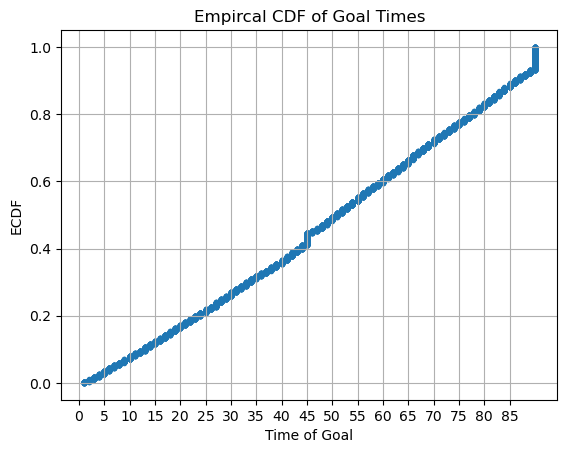

In [13]:

ecdf = ECDF(raw_times)
plt.scatter(ecdf.x, ecdf.y,marker='.')
plt.xlabel("Time of Goal")
plt.ylabel("ECDF")
plt.title("Empircal CDF of Goal Times")

plt.xticks(np.arange(0, 90, 5))

#add grid
plt.grid(True)
#save plot
plt.savefig("figures/goal_timing_EDCF.pdf")
plt.plot()
#get slopes


### First Goal Distribution
We next look at the distribution of first goals. Under the assumption of constant rates, the distribution should look somehwat exponential. The histogram and empirical CDF seem to confirm this as the histgoram looks exponential and the ECDF looks exponential with a changing rate at halftime. 

[]

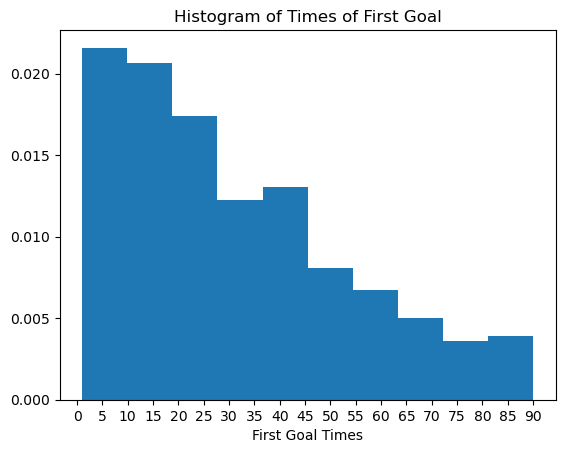

In [11]:
#distribution looks exponential, suggesting constant rate function
plt.hist(FG,bins = 10,density=True)
plt.xticks(np.arange(0, 100,5))
plt.xlabel("First Goal Times")
plt.title("Histogram of Times of First Goal")
plt.plot()

[]

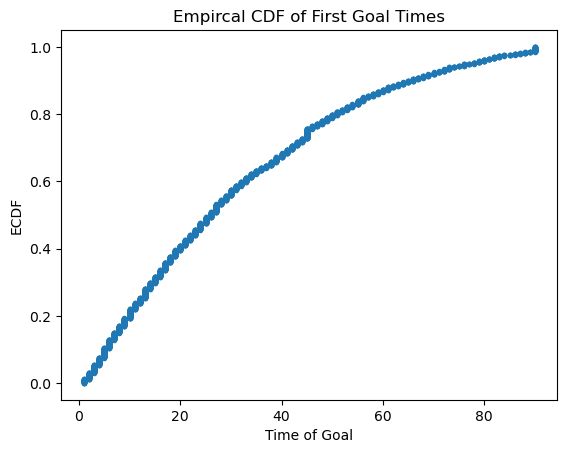

In [12]:
#ECDF of first goal times
ecdf = ECDF(FG)
plt.scatter(ecdf.x, ecdf.y,marker='.')
plt.xlabel("Time of Goal")
plt.ylabel("ECDF")
plt.title("Empircal CDF of First Goal Times")
plt.plot()
#get slopes
